# <center>Report of practical part of Assignment 3</center>
# <center>IFT6135-H19</center>

This file is used to generate the report for problem1-3 of practical part of assignment3.

Key codes are also included in this file. To review the whole codes for each problem, please turn to:

- models.py: implementation of RNN, GRU, TRANSFORMER for problem1-3; methods for 

in: https://github.com/qqiang00/IFT6135/blob/master/hw3/


**Team member**: 
- Qiang Ye (20139927)
- Ying Xiao (20111402)
- LiFeng Wan ()
- Yunhe Li (20137167)

In [1]:
from os.path import exists
from google.colab import drive
import os
drive.mount('/content/dirve/', force_remount = True)
# change to your own directory
os.chdir("dirve/My Drive/Colab Notebooks/IFT6135/hw3/")
#!ls -al
from IPython.display import Image

Mounted at /content/dirve/


In [2]:
import numpy as np
import torch.nn as nn
import torch
import random
import math
import matplotlib.pyplot as plt

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print(cuda)

True


## Understand Samplers.py

## Discriminator

In [15]:
############### import the sampler ``samplers.distribution4'' 
from samplers import distribution3, distribution4

############### train a discriminator on distribution4 and standard gaussian
class Discriminator(nn.Module):
    def __init__(self, input_dim = 2, hiddens = [128, 128]):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hiddens[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hiddens[0], hiddens[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hiddens[1], 1),
            #nn.Sigmoid(),
        )

    def forward(self, sample): # sample is sampling from a distribution
        validity = self.model(sample)
        return validity
    

def train_for_problem1_4(discriminator,  
                         dataset,
                         batch_size = 512,
                         max_epoch = 100, 
                         epoch_patience = 10,     # early stop patience
                         epsilon = 1e-12,         # for numerical stabiblity
          ):
    
    optimizer = torch.optim.SGD(discriminator.parameters(), lr=1e-3, momentum=0.9)
    min_loss = float('inf')    # minimal average loss of an epoch
    best_param_dict = discriminator.state_dict()  # best model parameters
    early_stop_delay = 0 
    discriminator.train()
    train_f1, train_f0, val_f1, val_f0 = dataset
    n_batch = train_f1.size(0) // batch_size
    for epoch in range(max_epoch):
        avg_train_loss = 0.
        for i in range(n_batch):

            train_f1_mini = train_f1[i: i + batch_size]
            train_f0_mini = train_f0[i: i + batch_size]
            
            train_f1_prob = torch.sigmoid(discriminator(train_f1_mini))#.view(batch_size, -1)
            train_f0_prob = torch.sigmoid(discriminator(train_f0_mini))#.view(batch_size, -1)
           
            train_f1_loss = -1 * torch.log2(train_f1_prob + epsilon).mean() 
            train_f0_loss = -1 * torch.log2(1 - train_f0_prob + epsilon).mean()
            d_loss = train_f1_loss + train_f0_loss
            
            optimizer.zero_grad()
            d_loss.backward()
            optimizer.step()
            
            cur_train_loss = d_loss.item()             
            avg_train_loss += cur_train_loss        # accumulate in one epoch
        
        avg_train_loss /= n_batch     # average loss in one eopch
        
        # check performance on val set
        val_f1_prob = torch.sigmoid(discriminator(val_f1))#.view(val_size, -1)
        val_f0_prob = torch.sigmoid(discriminator(val_f0))#.view(val_size, -1)
        val_loss = torch.log2(val_f1_prob).mean() + torch.log(val_f0_prob).mean()
        val_loss = -1 * val_loss.item()
            
        if val_loss < min_loss:
            min_loss = val_loss
            early_stop_delay = 0
            best_param_dict = discriminator.state_dict()
        else:
            early_stop_delay += 1
            if early_stop_delay >= epoch_patience:
                discriminator.load_state_dict(best_param_dict)
                print('early stop')
                return # discriminator
        print("[Epoch {:3}/{:3} Batch {:2}/{} train_loss:{}, val_loss:{}".format(
            1+epoch, max_epoch, i+1, n_batch, avg_train_loss, val_loss), end = " ")
        if early_stop_delay == 0:
            print("*")
        else:
            print("")
        
    discriminator.load_state_dict(best_param_dict)    
    return # discriminator


############# plot output of discriminator and density estimation
# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
# exact
x = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)

def output_and_density_estimation(discriminator, x):
    x = x.reshape(-1, )
    f0 = N(x)                   # Normal Distribution
    log_f0 = np.log(f0)         
    x = Tensor(x).view(-1, 1)   # 
    output = torch.sigmoid(discriminator(x)).data.cpu().numpy().reshape(-1, )
    log_f1 = log_f0 + np.log(output) - np.log(1-output)
    density_estimation = np.exp(log_f1)
    return output, density_estimation


############### estimate the density of distribution4
torch.manual_seed(0)
np.random.seed(7)
batch_size = 512
train_size, val_size = batch_size * 100, 50000
train_f1 = Tensor(next(distribution4(train_size)))
train_f0 = Tensor(next(distribution3(train_size)))

val_f1 = Tensor(next(distribution4(val_size)))
val_f0 = Tensor(next(distribution3(val_size)))
data_set = (train_f1, train_f0, val_f1, val_f0)

discriminator = Discriminator(input_dim = 1, hiddens = [128, 128])
if cuda:
    discriminator.cuda()
torch.manual_seed(0)
train_for_problem1_4(discriminator, 
                     data_set,
                     epoch_patience = 10, 
                     max_epoch = 100)

[Epoch   1/100 Batch 100/100 train_loss:1.8847099804878236, val_loss:1.584439754486084 *
[Epoch   2/100 Batch 100/100 train_loss:1.7894312858581543, val_loss:1.6716989278793335 
[Epoch   3/100 Batch 100/100 train_loss:1.7576133811473846, val_loss:1.7322912216186523 
[Epoch   4/100 Batch 100/100 train_loss:1.7492818021774292, val_loss:1.763077735900879 
[Epoch   5/100 Batch 100/100 train_loss:1.746782261133194, val_loss:1.7775852680206299 
[Epoch   6/100 Batch 100/100 train_loss:1.7455589485168457, val_loss:1.7835376262664795 
[Epoch   7/100 Batch 100/100 train_loss:1.7446853876113892, val_loss:1.7874665260314941 
[Epoch   8/100 Batch 100/100 train_loss:1.7439873003959656, val_loss:1.789245367050171 
[Epoch   9/100 Batch 100/100 train_loss:1.743389016389847, val_loss:1.7907004356384277 
[Epoch  10/100 Batch 100/100 train_loss:1.7428630948066712, val_loss:1.7917836904525757 
early stop


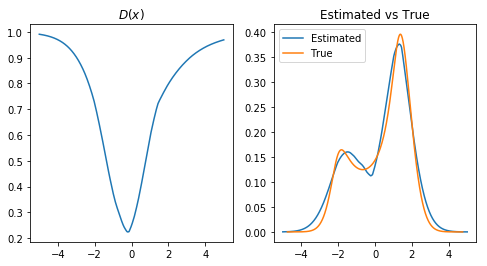

<Figure size 432x288 with 0 Axes>

In [16]:
xx = np.linspace(-5,5,1000)
output, estimate_density = output_and_density_estimation(discriminator, xx)

r = output # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

estimate = estimate_density
# estimate the density of distribution4 (on xx) using the discriminator; 
# replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')
plt.show()
plt.savefig("problem1_4_lite.png")

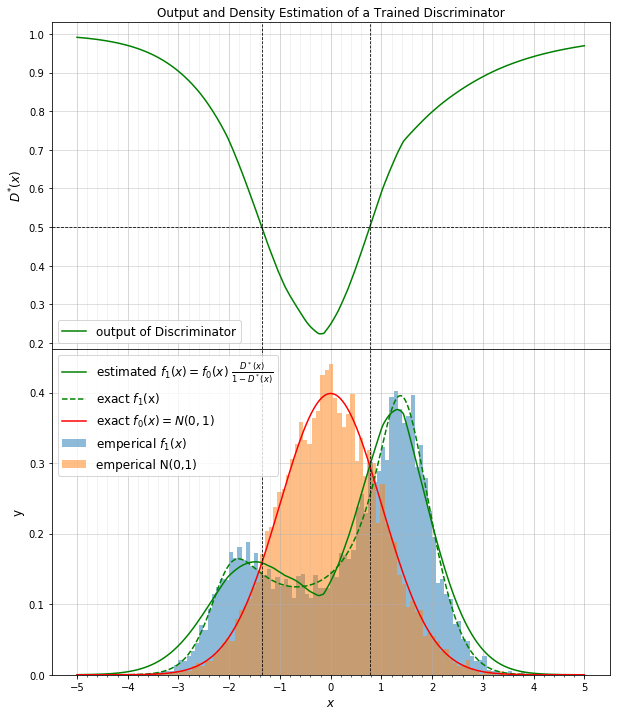

In [18]:
xx = torch.randn(10000)
x = np.linspace(-5,5,1000)
output, density = output_and_density_estimation(discriminator, x)

fontsize = 12

# look for xs where ys = 0.5
x0, x1 = -5, 5
interval = 1./100
for i, y in enumerate(output):
    if abs(y-0.5) < 0.005:
        if 300 < i < 500: x0 = -5 + interval * i
        if 500 < i < 700: x1 = -5 + interval * i
            
fig, axs = plt.subplots(2, 1, sharex=True, figsize = (10,12))
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-5.0, 5.1, 1.)
minor_ticks = np.arange(-5.0, 5.1, 0.2)

for ax in axs:
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

fig.subplots_adjust(hspace=0)
axs[0].plot(x, output, "-g", label = "output of Discriminator")
axs[0].set_ylabel('$D^{*}(x)$', fontsize = fontsize)
axs[0].set_title(r"Output and Density Estimation of a Trained Discriminator", 
                 fontsize = fontsize)
axs[0].legend(loc = "lower left", fontsize = 12)

#N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
axs[1].plot(x, density, "-g", label = r'estimated $f_1(x) = f_0(x)\  \frac{D^*(x)}{1-D^*(x)}$')
axs[1].hist(f(xx), 100, alpha=0.5, density=1, label = "emperical $f_1(x)$")
axs[1].plot(f(torch.from_numpy(x)).numpy(), d(torch.from_numpy(x)).numpy()**(-1)*N(x), 
            "--g", label = "exact $f_1$(x)")
axs[1].hist(xx, 100, alpha=0.5, density=1, label = "emperical N(0,1)")
axs[1].plot(x, N(x), "-r", label = r"exact $f_0(x) = N(0,1)$")
axs[1].legend(loc = "upper left", fontsize = 12)

axs[0].axhline(y=0.5, linewidth=0.8, linestyle = "--", color='#000000')
axs[1].axvline(x= x1, linewidth=0.8, linestyle = "--", color='#000000')
axs[0].axvline(x= x1, linewidth=0.8, linestyle = "--", color='#000000')
axs[1].axvline(x= x0, linewidth=0.8, linestyle = "--", color='#000000')
axs[0].axvline(x= x0, linewidth=0.8, linestyle = "--", color='#000000')

axs[1].set_xlabel(r'$x$', fontsize = fontsize)
axs[1].set_ylabel('y', fontsize = fontsize)
plt.show()
fig.savefig("problem1_4.png")